<a href="https://colab.research.google.com/github/Naisargi1402/Machine-Learning-Analysis/blob/main/predict_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from scipy import stats
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import seaborn as sns
import plotly
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm

In [ ]:
#read the data and put into dataframe
def read_data(csv):
    return pd.read_csv(csv)
data = read_data("risk_factors_cervical_cancer.csv")
data.replace("?", np.nan, inplace=True)
data.isna().sum()
data = data.apply(pd.to_numeric)
# remove columns that have less than half of the amount of rows as unknown
# replace unknown values with mean of column
def remove_unknowns(data):
    i = 0
    while i < data.shape[1]:
        if data.count().iloc[i] < data.shape[0]/2:
            data.drop(axis=1, labels=[data.columns[i]], inplace=True)
            i -= 1
        i += 1
    column_means = round(data.mean())
    data.fillna(column_means, inplace = True)
    return data

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


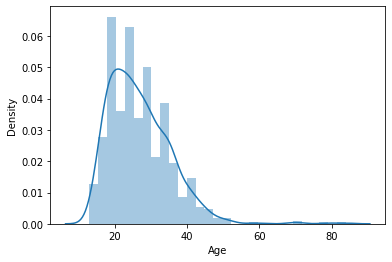

In [ ]:
data = remove_unknowns(data)
sns.distplot(data["Age"])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


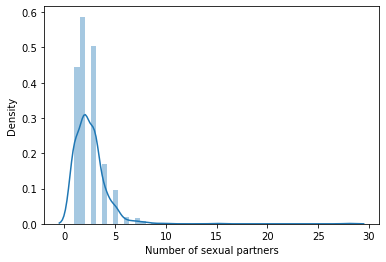

In [ ]:
sns.distplot(data["Number of sexual partners"], kde_kws={'bw': .3})

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


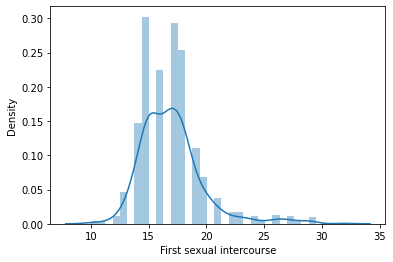

In [ ]:
sns.distplot(data["First sexual intercourse"])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


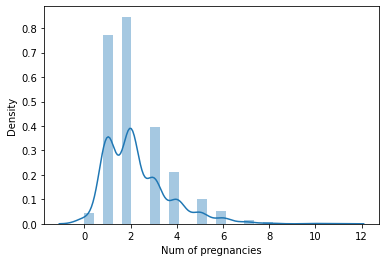

In [ ]:
sns.distplot(data["Num of pregnancies"])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


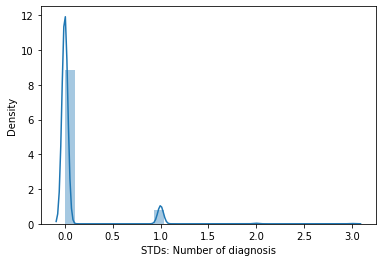

In [ ]:
sns.distplot(data["STDs: Number of diagnosis"], kde_kws={'bw': 0.1})

In [ ]:
#the risk factors are the features we are going to analyze
features = (data.iloc[0:858, 0:30])

#the four diagnoses are the target variables
hinselmann = data["Hinselmann"]
schiller = data["Schiller"]
citology = data["Citology"]
biopsy = data["Biopsy"]
#define a dictionary of estimators for model
estimators = {
    'k-Nearest Neighbor': KNeighborsClassifier(), 
    'Support Vector Machine': LinearSVC(max_iter=1000000),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier()}
#function that splits the data using percentage split (75% train 25% test)
def split_data(features, target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 3000)
    return X_train, X_test, y_train, y_test

In [ ]:
#split the data using percentage split
X_train_h, X_test_h, y_train_h, y_test_h = split_data(features, hinselmann)
X_train_s, X_test_s, y_train_s, y_test_s = split_data(features, schiller)
X_train_c, X_test_c, y_train_c, y_test_c = split_data(features, citology)
X_train_b, X_test_b, y_train_b, y_test_b = split_data(features, biopsy)
# preprocess using MinMaxScaler
def preprocessor(train, test):
    scaler = MinMaxScaler().fit(train)
    
    #scale testing and training sets
    X_train_scaled = scaler.transform(train)
    X_test_scaled = scaler.transform(test)

    return X_train_scaled, X_test_scaled
#preprocess the data
X_train_h_scaled, X_test_h_scaled = preprocessor(X_train_h, X_test_h)
X_train_s_scaled, X_test_s_scaled = preprocessor(X_train_s, X_test_s)
X_train_c_scaled, X_test_c_scaled = preprocessor(X_train_c, X_test_c)
X_train_b_scaled, X_test_b_scaled = preprocessor(X_train_b, X_test_b)

In [ ]:
#define dictionary of feature selection methods
feat_select_dict = {"UNI" : SelectKBest(score_func=f_classif, k = 3),
                    "MB" : SelectFromModel(DecisionTreeRegressor(random_state = 3000)),
                   "RFE" : RFE(DecisionTreeRegressor(random_state = 3000), n_features_to_select = 3)}
#set up dataframes to hold results of selecting features vs using all of the features
prelim_train_results = pd.DataFrame(index = ["Acc_All", "Acc_UNI", "Acc_MB", "Acc_RFE"])
prelim_test_results = pd.DataFrame(index = ["Acc_All", "Acc_UNI", "Acc_MB", "Acc_RFE"])
# Feature selection for each target variable and each selection method
def feature_selection(feat_select_dict, xtrain, xtest, ytrain, ytest, target):
    ml_model_all_train = LogisticRegression().fit(X=xtrain, y=ytrain)
    ml_model_all_test = LogisticRegression().fit(X=xtest, y=ytest)
    prelim_train_results.loc["Acc_All", target] = ml_model_all_train.score(xtrain, ytrain)
    prelim_test_results.loc["Acc_All", target] = ml_model_all_test.score(xtest, ytest)
    models = []
    
    for name, method in feat_select_dict.items():
        model = method
        model.fit(xtrain, ytrain)
        xtrain_selected = model.transform(xtrain)
        xtest_selected = model.transform(xtest)
        models.append(model)
        ml_model_selected_train = LogisticRegression().fit(X=xtrain_selected, y=ytrain)
        ml_model_selected_test = LogisticRegression().fit(X=xtest_selected, y=ytest)
        prelim_train_results.loc["Acc_" + name, target] = ml_model_selected_train.score(xtrain_selected, ytrain)
        prelim_test_results.loc["Acc_" + name, target] = ml_model_selected_test.score(xtest_selected, ytest)
    return prelim_train_results, prelim_test_results, models
prelim_train_results, prelim_test_results, models_h = feature_selection(feat_select_dict, X_train_h_scaled, X_test_h_scaled, y_train_h, y_test_h, "Hinselmann")
prelim_train_results, prelim_test_results, models_s = feature_selection(feat_select_dict, X_train_s_scaled, X_test_s_scaled, y_train_s, y_test_s, "Shiller")
prelim_train_results, prelim_test_results, models_c = feature_selection(feat_select_dict, X_train_c_scaled, X_test_c_scaled, y_train_c, y_test_c, "Citology")
prelim_train_results, prelim_test_results, models_b =  feature_selection(feat_select_dict, X_train_b_scaled, X_test_b_scaled, y_train_b, y_test_b, "Biopsy")

/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [14 18 19 21] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [14 18 19 21] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [14 18 19 21] are constant.
  warnings.warn("Features %s are constant." % constant_features_i

In [ ]:
features_list = []
#Selected features extraction
def extract_features(model):
    list = [i for i, val in enumerate(model.get_support()) if val]
    index=0
    while index < 3:
        print(features.columns[list][index])
        features_list.append(features.columns[list][index])
        index += 1

    return features_list
extract_features(models_h[0])
extract_features(models_h[1])
extract_features(models_h[2])
extract_features(models_s[0])
extract_features(models_s[1])
extract_features(models_s[2])
extract_features(models_c[0])
extract_features(models_c[1])
extract_features(models_c[2])
extract_features(models_b[0])
extract_features(models_b[1])
features_list = extract_features(models_b[2])

Dx:Cancer
Dx:HPV
Dx
Age
Number of sexual partners
First sexual intercourse
Age
Number of sexual partners
First sexual intercourse
Dx:Cancer
Dx:HPV
Dx
Age
Number of sexual partners
First sexual intercourse
Age
Number of sexual partners
First sexual intercourse
Dx:Cancer
Dx:HPV
Dx
Age
Number of sexual partners
First sexual intercourse
Age
Number of sexual partners
First sexual intercourse
Dx:Cancer
Dx:HPV
Dx
Age
Number of sexual partners
First sexual intercourse
Age
Number of sexual partners
First sexual intercourse


In [ ]:
#remove duplicates in the list
features_list = list(set(features_list))
#remove columns that are not the selected features
def select_features_in_data(x, features, columns_list):
    x_selected = pd.DataFrame(x, columns = features)
    x_selected = x_selected.drop(columns = [col for col in x_selected if col not in columns_list])
    return x_selected
X_train_h_selected = select_features_in_data(X_train_h_scaled, list(features.columns), features_list)
X_test_h_selected = select_features_in_data(X_test_h_scaled, list(features.columns), features_list)
X_train_s_selected = select_features_in_data(X_train_s_scaled, list(features.columns), features_list)
X_test_s_selected = select_features_in_data(X_test_s_scaled, list(features.columns), features_list)
X_train_c_selected = select_features_in_data(X_train_c_scaled, list(features.columns), features_list)
X_test_c_selected = select_features_in_data(X_test_c_scaled, list(features.columns), features_list)
X_train_b_selected = select_features_in_data(X_train_b_scaled, list(features.columns), features_list)
X_test_b_selected = select_features_in_data(X_test_b_scaled, list(features.columns), features_list)

In [ ]:
#put the four target variables in a dataframe
features_list.append("Hinselmann")
features_list.append("Schiller")
features_list.append("Citology")
features_list.append("Biopsy")

#show dataframe of selected data
selected_data = data.drop(columns = [col for col in data if col not in features_list])

#CLEANING: clean up strings so they can used as numbers
for columns in selected_data:
    selected_data[columns] = pd.to_numeric(selected_data[columns])
selected_feature_data = [X_train_h_selected, X_test_h_selected, X_train_s_selected, X_test_s_selected , X_train_c_selected, X_test_c_selected, 
                X_train_b_selected, X_test_b_selected]
for df in selected_feature_data:
    df.drop("Dx:Cancer", axis=1, inplace = True)

    
hypothesis_data = data[["Age", "Number of sexual partners", "First sexual intercourse", "Num of pregnancies", "Smokes (years)", "Hormonal Contraceptives (years)", "Hinselmann", "Schiller", "Citology", "Biopsy"]]

In [ ]:
# since we are doing T Test, we have to make sure that all the columns in our dataset are binary
# to transfer the columns into binary values
import numpy as np 

age_range_0 = np.arange(12, 40)
age_range_1 = np.arange(39, 85)

sex_part_0 = np.arange(0, 5)
sex_part_1 = np.arange(5, 29)

first_sex_0 = np.arange(16)
first_sex_1 = np.arange(15, 33)

num_preg_0 = np.arange(4)
num_preg_1 = np.arange(3, 12)

#CLEANING: clean up strings so they can used as numbers
for columns in selected_data:
    selected_data[columns] = pd.to_numeric(selected_data[columns])
    
def trans_to_binary(data):
    smoke_range = data["Smokes (years)"]

    for years in smoke_range:
        if years < 1:
            data["Smokes (years)"].replace(years, 0, inplace=True)
        else:
            data["Smokes (years)"].replace(years, 1, inplace=True)
        
    hor_range = data['Hormonal Contraceptives (years)']

    for years in hor_range:
        if years < 1:
            data['Hormonal Contraceptives (years)'].replace(years, 0, inplace=True)
        else:
            data['Hormonal Contraceptives (years)'].replace(years, 1, inplace=True)
    data["Age"].replace(age_range_0, 0, inplace=True)
    data["Age"].replace(age_range_1, 1, inplace=True)
    data["Number of sexual partners"].replace(sex_part_0, 0, inplace=True)
    data["Number of sexual partners"].replace(sex_part_1, 1, inplace=True)
    data["First sexual intercourse"].replace(first_sex_0, 0, inplace=True)
    data["First sexual intercourse"].replace(first_sex_1, 1, inplace=True)
    data["Num of pregnancies"].replace(num_preg_0, 0, inplace=True)
    data["Num of pregnancies"].replace(num_preg_1, 1, inplace=True)
    return data

hp_test = trans_to_binary(hypothesis_data)
hp_test

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes (years),Hormonal Contraceptives (years),Hinselmann,Schiller,Citology,Biopsy
0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
1,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
2,0,0.0,1.0,0.0,0.0,0.0,0,0,0,0
3,1,1.0,1.0,1.0,1.0,1.0,0,0,0,0
4,1,0.0,1.0,1.0,0.0,1.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
853,0,0.0,1.0,0.0,0.0,0.0,0,0,0,0
854,0,0.0,1.0,0.0,0.0,1.0,0,0,0,0
855,0,0.0,1.0,0.0,0.0,0.0,0,0,1,0
856,0,0.0,1.0,0.0,0.0,0.0,0,0,0,0


In [ ]:
def f_test(data,IV,DV):
    catego = [x[1] for x in data.groupby(IV)[DV]]
    f_statistics, p_values = stats.f_oneway( * catego)
    df1 = len(data.groupby(IV)[DV]) - 1
    df2 = sum([len(x[1])-1 for x in data.groupby(IV)[DV]])
    print(str(IV) + " ---- F-test")
    print("------------------------------" + "\n")
    print("F("+format(df1,'d')+","+format(df2,'d')+") = " + format(f_statistics,'.2f') + " , p = "+format(p_values,'.4f')+"\n")
    print("------------------------------" + "\n")

def t_test(data,IV,DV):
    results = stats.ttest_rel(data[IV],data[DV])
    #t value
    tstatistic = results[0]
    #p value in scientific notation
    pvalue = results[1]
    print(str(IV) + " ---- t-test")
    print("------------------------------" + "\n")
    print("t-value ="+format(tstatistic,'.2f')+"   pvalue = "+format(pvalue,'.10f')+"\n")
    if(pvalue<0.05):
        print("pvalue is not significant\n")
        print("------------------------------" + "\n")

    else:
        print("pvalue is significant\n")
        print("------------------------------" + "\n")

def check_levene(data,IV,DV):
    catego = [x[1] for x in data.groupby(IV)[DV]]
    levene_results = stats.levene( * catego)
    print(str(IV) +  "\n" + " Assumption of Equality of Variances:")
    print("\t", end = "")
    print(levene_results)
    if (levene_results[1] > 0.05):
        print("\t\t"+"Assumption is met. p > .05" + "\n")
    else:
        print("\t\t"+"Assumption is not met, p < 0.05" + "\n")

        
def check_shapiro(data,IV,DV):
    shapiro = data.groupby(IV)[DV].agg(lambda x : stats.shapiro(x))
    print(str(IV) +  "\n" + "Assumption of Normality:")
    for i in range (shapiro.size):
        print("\n",end = "")
        print(shapiro.index[i], end = " : ")
        print(end = "")
        print(shapiro.iloc[i])
        if(shapiro.iloc[i][1]>0.05):
            print("\t\t"+"Assumption is met. p > .05"+  "\n"+  "\n")
        else:
            print("\t\t"+"Assumption is not met, p < 0.05"+  "\n"+  "\n")

In [ ]:
# for target "Hinselmann"
features = (hp_test.iloc[0:858, 0:6])
for fea in features:
    f_test(hp_test, fea, "Hinselmann")
    t_test(hp_test, fea, "Hinselmann")
    check_levene(hp_test, fea, "Hinselmann")
    check_shapiro(hp_test, fea, "Hinselmann")
# for target "Schiller"
features = (hp_test.iloc[0:858, 0:6])
for fea in features:
    f_test(hp_test, fea, "Schiller")
    t_test(hp_test, fea, "Schiller")
    check_levene(hp_test, fea, "Schiller")
    check_shapiro(hp_test, fea, "Schiller")
# for target "Citology"
features = (hp_test.iloc[0:858, 0:6])
for fea in features:
    f_test(hp_test, fea, "Citology")
    t_test(hp_test, fea, "Citology")
    check_levene(hp_test, fea, "Citology")
    check_shapiro(hp_test, fea, "Citology")
    
# for target "Biopsy"
features = (hp_test.iloc[0:858, 0:6])
for fea in features:
    f_test(hp_test, fea, "Biopsy")
    t_test(hp_test, fea, "Biopsy")
    check_levene(hp_test, fea, "Biopsy")
    check_shapiro(hp_test, fea, "Biopsy")

Age ---- F-test
------------------------------

F(1,856) = 0.18 , p = 0.6713

------------------------------

Age ---- t-test
------------------------------

t-value =3.08   pvalue = 0.0021579098

pvalue is not significant

------------------------------

Age
 Assumption of Equality of Variances:
	LeveneResult(statistic=0.18019152801173444, pvalue=0.6713153616025822)
		Assumption is met. p > .05

Age
Assumption of Normality:

0 : ShapiroResult(statistic=0.198458731174469, pvalue=0.0)
		Assumption is not met, p < 0.05



1 : ShapiroResult(statistic=0.16593515872955322, pvalue=2.2599616582520533e-17)
		Assumption is not met, p < 0.05


Number of sexual partners ---- F-test
------------------------------

F(1,856) = 1.28 , p = 0.2576

------------------------------

Number of sexual partners ---- t-test
------------------------------

t-value =3.30   pvalue = 0.0009978571

pvalue is not significant

------------------------------

Number of sexual partners
 Assumption of Equality of Varia

In [ ]:
#create data frame to hold all results
df_accuracy = pd.DataFrame(index=["Accuracy-Selected", "Accuracy-All"])
df_f1 = pd.DataFrame(index=["F1 Score-Selected", "F1 Score-All"])
#function that applies the algorithms to the data
def apply_algorithms(target, features, x_train, x_test, ytrain, ytest):
    for estimator_name, estimator_object in estimators.items():
        #fit scaled sets to model
        estimator_object.fit(X=x_train, y=ytrain)
        #make predictions on the test set
        predicted = estimator_object.predict(X=x_test)
        expected = ytest
        #display classification metric results
        accuracy = estimator_object.score(x_test, ytest)
        f1score = f1_score(y_true=expected, y_pred=predicted, average=None)[0]
        df_accuracy.loc["Accuracy-" + features, target + ": " + estimator_name] = accuracy
        df_f1.loc["F1 Score-" + features, target + ": " + estimator_name] = f1score
        print(target)
        print(estimator_name + ": \n\t" + "Prediction accuracy on the test data:", f"{accuracy:.2%}" + "\n")
        print("\tF1 Score: " + str(f1score) + "\n")
        
#results
print('TEST RESULTS WHEN ONLY SELECTED FEATURES USED:')
print('___________________________________________\n')
print('With Selected Features')
apply_algorithms("Hinselmann", "Selected", X_train_h_selected, X_test_h_selected, y_train_h, y_test_h)
apply_algorithms("Schiller", "Selected", X_train_s_selected, X_test_s_selected, y_train_s, y_test_s)
apply_algorithms("Citology", "Selected", X_train_c_selected, X_test_c_selected, y_train_c, y_test_c)
apply_algorithms("Biopsy", "Selected", X_train_b_selected, X_test_b_selected, y_train_b, y_test_b)
print('\nTEST RESULTS WHEN ALL FEATURES USED:')
print('____________________________________\n')
print('With All Features')
apply_algorithms("Hinselmann", "All", X_train_h_scaled, X_test_h_scaled, y_train_h, y_test_h)
apply_algorithms("Schiller", "All", X_train_s_scaled, X_test_s_scaled, y_train_s, y_test_s)
apply_algorithms("Citology", "All", X_train_c_scaled, X_test_c_scaled, y_train_c, y_test_c)
apply_algorithms("Biopsy", "All", X_train_b_scaled, X_test_b_scaled, y_train_b, y_test_b)

TEST RESULTS WHEN ONLY SELECTED FEATURES USED:
___________________________________________

With Selected Features
Hinselmann
k-Nearest Neighbor: 
	Prediction accuracy on the test data: 96.74%

	F1 Score: 0.983451536643026

Hinselmann
Support Vector Machine: 
	Prediction accuracy on the test data: 96.74%

	F1 Score: 0.983451536643026

Hinselmann
Logistic Regression: 
	Prediction accuracy on the test data: 96.74%

	F1 Score: 0.983451536643026

Hinselmann
Decision Tree: 
	Prediction accuracy on the test data: 93.02%

	F1 Score: 0.963855421686747

Schiller
k-Nearest Neighbor: 
	Prediction accuracy on the test data: 89.77%

	F1 Score: 0.946078431372549

Schiller
Support Vector Machine: 
	Prediction accuracy on the test data: 90.23%

	F1 Score: 0.9486552567237164

Schiller
Logistic Regression: 
	Prediction accuracy on the test data: 91.63%

	F1 Score: 0.9563106796116505

Schiller
Decision Tree: 
	Prediction accuracy on the test data: 88.84%

	F1 Score: 0.9405940594059405

Citology
k-Nearest

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

k-Nearest Neighbor: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       208
           1       0.00      0.00      0.00         7

    accuracy                           0.97       215
   macro avg       0.48      0.50      0.49       215
weighted avg       0.94      0.97      0.95       215

0.9674418604651163
Support Vector Machine: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       208
           1       0.00      0.00      0.00         7

    accuracy                           0.97       215
   macro avg       0.48      0.50      0.49       215
weighted avg       0.94      0.97      0.95       215

0.9674418604651163
Logistic Regression: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       208
           1       0.00      0.00      0.00         7

    accuracy                           0.97       215
   macro avg       0.4

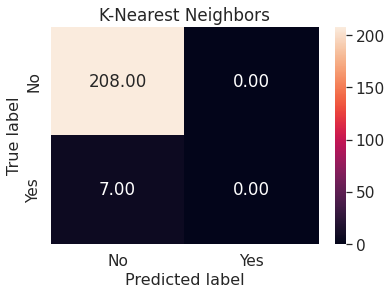

In [ ]:
#Calculate average by algorithm
def calc_avg_for_algorithms(df, algorithm):
    list = [column for column in df.columns.tolist() if algorithm in column]
    return pd.DataFrame(data = df[list]).mean(axis = 1)

average_accuracies = {"KNN" : calc_avg_for_algorithms(df_accuracy, "Neighbor"),
            "SVM": calc_avg_for_algorithms(df_accuracy, "Support"),
            "Logistic Regression": calc_avg_for_algorithms(df_accuracy, "Logistic"),
            "Decision Tree": calc_avg_for_algorithms(df_accuracy, "Decision Tree")}
pd.DataFrame(average_accuracies)
average_f1s = {"KNN" : calc_avg_for_algorithms(df_f1, "Neighbor"),
            "SVM": calc_avg_for_algorithms(df_f1, "Support"),
            "Logistic Regression": calc_avg_for_algorithms(df_f1, "Logistic"),
            "Decision Tree": calc_avg_for_algorithms(df_f1, "Decision Tree")}

#Create a confusion matrix to evaluate performance given the training and test data
def confusion_matrix(xtrain, xtest, ytrain, ytest):
    
    cms = []
    
    for estimator_name, estimator_object in estimators.items():
        
        #fit scaled sets to model
        estimator_object.fit(xtrain, ytrain)
        
        #make predictions on the test set
        predicted = estimator_object.predict(xtest)
        expected = ytest 
        
        pred_log = estimator_object.predict(xtest)

        cm = metrics.confusion_matrix(ytest, pred_log)
        cms.append(cm)

        print(estimator_name + ": \n" + metrics.classification_report(ytest,pred_log,digits=2))
        
        # the accuracy score 
        print(metrics.accuracy_score(ytest,pred_log))
        
    return cms

#Create a heatmap to visualize the confusion matrix of the given algorithm's performance
def heatmap(confusion_matrix, algorithm):
    sns.set(font_scale=1.4)
    sns.heatmap(confusion_matrix, annot=True,  fmt='.2f', xticklabels = ["No", "Yes"] , yticklabels = ["No", "Yes"])
    plt.ylabel('True label',fontsize=16)
    plt.xlabel('Predicted label',fontsize=16)
    plt.title(algorithm)
cm_h=confusion_matrix(X_train_h_selected,X_test_h_selected,y_train_h,y_test_h)   
heatmap(cm_h[0], "K-Nearest Neighbors")

In [ ]:
#optimize the LogisticRegression algorithm
param_grid = {'C':[.001, .01, .1, 1, 10, 100]}
def grid_search_lr(target, xtrain, xtest, ytrain, ytest):
    
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
    
    grid_search.fit(X=xtrain, y=ytrain)
    
    print("Best parameters: ", grid_search.best_params_)
    print("Training set score with best parameters", grid_search.best_score_)
    print("Test set score with best parameters:", grid_search.score(xtest, ytest))

grid_search_lr(hinselmann, X_train_h_selected, X_test_h_selected, y_train_h, y_test_h)

#define estimators to be Logistic Regression and Decision Tree algorithm
estimators = {"Logistic Regression" : LogisticRegression(C = .001), "Decision Tree" : DecisionTreeClassifier(max_depth=1, min_samples_leaf=1, min_samples_split=2)}
#results for tuned Logistic Regression and Decision Tree Algorithm
#test with selected features
print('With Selected Features')
apply_algorithms("Hinselmann", "Selected", X_train_h_selected, X_test_h_selected, y_train_h, y_test_h)
apply_algorithms("Schiller", "Selected", X_train_s_selected, X_test_s_selected, y_train_s, y_test_h)
apply_algorithms("Citology", "Selected", X_train_c_selected, X_test_c_selected, y_train_c, y_test_c)
apply_algorithms("Biopsy", "Selected", X_train_b_selected, X_test_b_selected, y_train_b, y_test_b)

Best parameters:  {'C': 0.001}
Training set score with best parameters 0.9564680232558139
Test set score with best parameters: 0.9674418604651163
With Selected Features
Hinselmann
Logistic Regression: 
	Prediction accuracy on the test data: 96.74%

	F1 Score: 0.983451536643026

Hinselmann
Decision Tree: 
	Prediction accuracy on the test data: 96.74%

	F1 Score: 0.983451536643026

Schiller
Logistic Regression: 
	Prediction accuracy on the test data: 96.74%

	F1 Score: 0.983451536643026

Schiller
Decision Tree: 
	Prediction accuracy on the test data: 96.74%

	F1 Score: 0.983451536643026

Citology
Logistic Regression: 
	Prediction accuracy on the test data: 95.35%

	F1 Score: 0.9761904761904763

Citology
Decision Tree: 
	Prediction accuracy on the test data: 95.35%

	F1 Score: 0.9761904761904763

Biopsy
Logistic Regression: 
	Prediction accuracy on the test data: 93.49%

	F1 Score: 0.9663461538461539

Biopsy
Decision Tree: 
	Prediction accuracy on the test data: 93.49%

	F1 Score: 0.96634